# Northwind database

Northwind is a company that sells specialty foods. I was given a mandate to  "__do something with this database__" as my first project as a new hire. Unfortunatly at the end of last week, the whole computer science division got sick. It was someone's birthday and they all ate bad sheet cake. I wasn't aware those could *actually* go bad.

I was able to find a entity-relation diagram for the database but not much else. So to break down this task:
1. First I am going to have to explore the database myself to see the basic metrics of the company.
2. Then I will use this basic data to formulate some hypotheses concerning some underlying trends.
3. Finally I will attempt to test out these ideas to prove myself right or wrong.

## EDA

In [156]:
import sqlalchemy
from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import Session, sessionmaker #importing libraries I will use. This list has been added as I progressed throughout the notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from scipy.stats import ttest_1samp
from scipy.stats import levene, shapiro, probplot

In [2]:
#engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()

inspector = inspect(engine) #checking the ERD against the actual database
inspector.get_table_names()

2019-01-27 09:44:06,215 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-01-27 09:44:06,217 INFO sqlalchemy.engine.base.Engine ()
2019-01-27 09:44:06,220 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-01-27 09:44:06,221 INFO sqlalchemy.engine.base.Engine ()
2019-01-27 09:44:06,223 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-01-27 09:44:06,224 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

So found my first discrepancy, most the table names are stated as singular while the ERD have them as plural.  
  
I will submit a ticket to the deparment to fix this when they get back.

In [3]:
inspector.get_columns('Product')

2019-01-27 09:44:06,240 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")
2019-01-27 09:44:06,241 INFO sqlalchemy.engine.base.Engine ()


[{'name': 'Id',
  'type': INTEGER(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'ProductName',
  'type': VARCHAR(length=8000),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'SupplierId',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'CategoryId',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'QuantityPerUnit',
  'type': VARCHAR(length=8000),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'UnitPrice',
  'type': DECIMAL(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'UnitsInStock',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'UnitsOnOrder',
  'type': INTEGER(),
  'n

A bit messy, I recall a function that I had used previously that I could use to help in cleaning this up.

In [4]:
def get_column_info(col_name): #quick function based on https://github.com/learn-co-curriculum/dsc-2-13-11-queries-with-sqlalchemy-lab
    col_list = inspector.get_columns(col_name)
    print(f'Table Name: {col_name} \n')
    
    for col in col_list:
        if col['primary_key'] == 1:
            print(f"{col['name']}  ||PRIMARY KEY||  dtype: {col['type']}")
        else:
            print(f"{col['name']}     dtype: {col['type']}")
                  

In [5]:
get_column_info('Product')

Table Name: Product 

Id  ||PRIMARY KEY||  dtype: INTEGER
ProductName     dtype: VARCHAR(8000)
SupplierId     dtype: INTEGER
CategoryId     dtype: INTEGER
QuantityPerUnit     dtype: VARCHAR(8000)
UnitPrice     dtype: DECIMAL
UnitsInStock     dtype: INTEGER
UnitsOnOrder     dtype: INTEGER
ReorderLevel     dtype: INTEGER
Discontinued     dtype: INTEGER


In [6]:
get_column_info('Employee')

2019-01-27 09:44:06,317 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-01-27 09:44:06,318 INFO sqlalchemy.engine.base.Engine ()
Table Name: Employee 

Id  ||PRIMARY KEY||  dtype: INTEGER
LastName     dtype: VARCHAR(8000)
FirstName     dtype: VARCHAR(8000)
Title     dtype: VARCHAR(8000)
TitleOfCourtesy     dtype: VARCHAR(8000)
BirthDate     dtype: VARCHAR(8000)
HireDate     dtype: VARCHAR(8000)
Address     dtype: VARCHAR(8000)
City     dtype: VARCHAR(8000)
Region     dtype: VARCHAR(8000)
PostalCode     dtype: VARCHAR(8000)
Country     dtype: VARCHAR(8000)
HomePhone     dtype: VARCHAR(8000)
Extension     dtype: VARCHAR(8000)
Photo     dtype: BLOB
Notes     dtype: VARCHAR(8000)
ReportsTo     dtype: INTEGER
PhotoPath     dtype: VARCHAR(8000)


In [7]:
get_column_info('Supplier')

2019-01-27 09:44:06,332 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Supplier")
2019-01-27 09:44:06,333 INFO sqlalchemy.engine.base.Engine ()
Table Name: Supplier 

Id  ||PRIMARY KEY||  dtype: INTEGER
CompanyName     dtype: VARCHAR(8000)
ContactName     dtype: VARCHAR(8000)
ContactTitle     dtype: VARCHAR(8000)
Address     dtype: VARCHAR(8000)
City     dtype: VARCHAR(8000)
Region     dtype: VARCHAR(8000)
PostalCode     dtype: VARCHAR(8000)
Country     dtype: VARCHAR(8000)
Phone     dtype: VARCHAR(8000)
Fax     dtype: VARCHAR(8000)
HomePage     dtype: VARCHAR(8000)


  
So a quick check of the different tables align with the ERD. That is good. But I should be checking out the individual tables before calling them nevertheless, it is good pratice.
  
Now lets start checking out a few things:
- How much of what are we selling?
- Who are our main suppliers?
- What does our customer base look like?
- What is the geographical spread of our workforce?

Once we know these things, we will have a broad overview of the business. From there we will investigate any abnormalities or go splunking for underlying trends.
___
---
Now lets make a connect to the engine and make sure it works.

In [8]:
con = engine.connect() #connecting the engine to be able to make queries

In [9]:
q = '''SELECT * FROM Product''' #simple query
df_product = pd.read_sql_query(q, engine) #puts the information from the query into a dataframe
df_product.head()

2019-01-27 09:44:06,372 INFO sqlalchemy.engine.base.Engine SELECT * FROM Product
2019-01-27 09:44:06,373 INFO sqlalchemy.engine.base.Engine ()


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


Fantasic, now lets start flushing out answers to those inital questions

## How much of what are we selling?

Lets check the Product table and the Order Detail table

In [10]:
print(get_column_info('Product'))
print(get_column_info('OrderDetail'))
print(get_column_info('Category'))

Table Name: Product 

Id  ||PRIMARY KEY||  dtype: INTEGER
ProductName     dtype: VARCHAR(8000)
SupplierId     dtype: INTEGER
CategoryId     dtype: INTEGER
QuantityPerUnit     dtype: VARCHAR(8000)
UnitPrice     dtype: DECIMAL
UnitsInStock     dtype: INTEGER
UnitsOnOrder     dtype: INTEGER
ReorderLevel     dtype: INTEGER
Discontinued     dtype: INTEGER
None
2019-01-27 09:44:06,413 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-01-27 09:44:06,414 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail 

Id  ||PRIMARY KEY||  dtype: VARCHAR(8000)
OrderId     dtype: INTEGER
ProductId     dtype: INTEGER
UnitPrice     dtype: DECIMAL
Quantity     dtype: INTEGER
Discount     dtype: FLOAT
None
2019-01-27 09:44:06,418 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-01-27 09:44:06,419 INFO sqlalchemy.engine.base.Engine ()
Table Name: Category 

Id  ||PRIMARY KEY||  dtype: INTEGER
CategoryName     dtype: VARCHAR(8000)
Description     dtype: VARCH

Looks like the table is ERD is wrong again. Some of the tables are incorrectly stated i.e. ProductID is just Id

In [11]:
q='''SELECT p.ProductName, c.CategoryName, SUM(o.Quantity) num_ordered \
FROM Product p \
LEFT JOIN OrderDetail o ON o.ProductId = p.Id \
LEFT JOIN Category c ON c.Id = p.CategoryId \
GROUP BY p.ProductName ORDER BY num_ordered DESC'''
df1 = pd.read_sql_query(q, engine)
df1.head()

2019-01-27 09:44:06,431 INFO sqlalchemy.engine.base.Engine SELECT p.ProductName, c.CategoryName, SUM(o.Quantity) num_ordered FROM Product p LEFT JOIN OrderDetail o ON o.ProductId = p.Id LEFT JOIN Category c ON c.Id = p.CategoryId GROUP BY p.ProductName ORDER BY num_ordered DESC
2019-01-27 09:44:06,432 INFO sqlalchemy.engine.base.Engine ()


,ProductName,CategoryName,num_ordered
0,Camembert Pierrot,Dairy Products,1577
1,Raclette Courdavault,Dairy Products,1496
2,Gorgonzola Telino,Dairy Products,1397
3,Gnocchi di nonna Alice,Grains/Cereals,1263
4,Pavlova,Confections,1158


In [12]:
df1.CategoryName.value_counts()

Confections       13
Beverages         12
Seafood           12
Condiments        12
Dairy Products    10
Grains/Cereals     7
Meat/Poultry       6
Produce            5
Name: CategoryName, dtype: int64

So looks like confections is the kind of food we have the most orders for.

## Who are our main suppliers?

In [13]:
print(get_column_info('Order'))
print(get_column_info('Supplier'))

2019-01-27 09:44:06,480 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-01-27 09:44:06,481 INFO sqlalchemy.engine.base.Engine ()
Table Name: Order 

Id  ||PRIMARY KEY||  dtype: INTEGER
CustomerId     dtype: VARCHAR(8000)
EmployeeId     dtype: INTEGER
OrderDate     dtype: VARCHAR(8000)
RequiredDate     dtype: VARCHAR(8000)
ShippedDate     dtype: VARCHAR(8000)
ShipVia     dtype: INTEGER
Freight     dtype: DECIMAL
ShipName     dtype: VARCHAR(8000)
ShipAddress     dtype: VARCHAR(8000)
ShipCity     dtype: VARCHAR(8000)
ShipRegion     dtype: VARCHAR(8000)
ShipPostalCode     dtype: VARCHAR(8000)
ShipCountry     dtype: VARCHAR(8000)
None
Table Name: Supplier 

Id  ||PRIMARY KEY||  dtype: INTEGER
CompanyName     dtype: VARCHAR(8000)
ContactName     dtype: VARCHAR(8000)
ContactTitle     dtype: VARCHAR(8000)
Address     dtype: VARCHAR(8000)
City     dtype: VARCHAR(8000)
Region     dtype: VARCHAR(8000)
PostalCode     dtype: VARCHAR(8000)
Country     dtype: VARCHAR(8000)
Phone   

In [14]:
q = '''SELECT s.CompanyName, s.Region, COUNT(*) num_of_orders FROM [Order] o \
LEFT JOIN OrderDetail od ON o.Id = od.OrderId \
LEFT JOIN Product p ON od.ProductId = p.Id \
LEFT JOIN Supplier s ON p.SupplierId = s.Id \
GROUP BY s.CompanyName \
ORDER BY num_of_orders DESC'''

df2 = pd.read_sql_query(q, engine)
df2.head()

2019-01-27 09:44:06,534 INFO sqlalchemy.engine.base.Engine SELECT s.CompanyName, s.Region, COUNT(*) num_of_orders FROM [Order] o LEFT JOIN OrderDetail od ON o.Id = od.OrderId LEFT JOIN Product p ON od.ProductId = p.Id LEFT JOIN Supplier s ON p.SupplierId = s.Id GROUP BY s.CompanyName ORDER BY num_of_orders DESC
2019-01-27 09:44:06,536 INFO sqlalchemy.engine.base.Engine ()


,CompanyName,Region,num_of_orders
0,Plutzer Lebensmittelgroßmärkte AG,Western Europe,179
1,"Pavlova, Ltd.",Victoria,163
2,"Specialty Biscuits, Ltd.",British Isles,126
3,Gai pâturage,Western Europe,105
4,Norske Meierier,Scandinavia,105


In [15]:
df2.Region.value_counts(), df2.num_of_orders.mean()

(Western Europe     6
 North America      6
 Northern Europe    4
 Southern Europe    3
 Scandinavia        2
 Eastern Asia       2
 British Isles      2
 NSW                1
 Victoria           1
 South-East Asia    1
 South America      1
 Name: Region, dtype: int64, 74.3103448275862)

The largest amount of orders come from Western Europe and it is one of the largest portion of our supply chain.

## What does our customer base look like?

In [16]:
print(get_column_info('CustomerDemographic'))
print(get_column_info('Customer'))
print(get_column_info('CustomerCustomerDemo'))

2019-01-27 09:44:06,594 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerDemographic")
2019-01-27 09:44:06,595 INFO sqlalchemy.engine.base.Engine ()
Table Name: CustomerDemographic 

Id  ||PRIMARY KEY||  dtype: VARCHAR(8000)
CustomerDesc     dtype: VARCHAR(8000)
None
2019-01-27 09:44:06,600 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-01-27 09:44:06,601 INFO sqlalchemy.engine.base.Engine ()
Table Name: Customer 

Id  ||PRIMARY KEY||  dtype: VARCHAR(8000)
CompanyName     dtype: VARCHAR(8000)
ContactName     dtype: VARCHAR(8000)
ContactTitle     dtype: VARCHAR(8000)
Address     dtype: VARCHAR(8000)
City     dtype: VARCHAR(8000)
Region     dtype: VARCHAR(8000)
PostalCode     dtype: VARCHAR(8000)
Country     dtype: VARCHAR(8000)
Phone     dtype: VARCHAR(8000)
Fax     dtype: VARCHAR(8000)
None
2019-01-27 09:44:06,606 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerCustomerDemo")
2019-01-27 09:44:06,607 INFO sqlalchemy.engine.base.Engine ()

In [17]:
q = '''SELECT * FROM CustomerCustomerDemo'''

df3 = pd.read_sql_query(q, engine)
df3

2019-01-27 09:44:06,626 INFO sqlalchemy.engine.base.Engine SELECT * FROM CustomerCustomerDemo
2019-01-27 09:44:06,628 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerTypeId


It looks like `CustomerCustomerDemo` is an empty table. This must be a new table or something went wrong. That means the only customer data I have to look at will from the customer table. Another ticket I need to submit.

In [173]:
q = '''SELECT ContactTitle, Count(*) num_of_types \
FROM Customer  \
GROUP BY ContactTitle  \
ORDER BY num_of_types DESC'''

df4 = pd.read_sql_query(q, engine)
df4

2019-01-27 15:24:50,632 INFO sqlalchemy.engine.base.Engine SELECT ContactTitle, Count(*) num_of_types FROM Customer  GROUP BY ContactTitle  ORDER BY num_of_types DESC
2019-01-27 15:24:50,633 INFO sqlalchemy.engine.base.Engine ()


,ContactTitle,num_of_types
0,Owner,17
1,Sales Representative,17
2,Marketing Manager,12
3,Sales Manager,11
4,Accounting Manager,10
5,Sales Associate,7
6,Marketing Assistant,6
7,Sales Agent,5
8,Assistant Sales Agent,2
9,Order Administrator,2


In [19]:
q = '''SELECT Region, Count(*) num_of_customers \
FROM Customer  \
GROUP BY Region  \
ORDER BY num_of_customers DESC'''

df5 = pd.read_sql_query(q, engine)
df5

2019-01-27 09:44:06,689 INFO sqlalchemy.engine.base.Engine SELECT Region, Count(*) num_of_customers FROM Customer  GROUP BY Region  ORDER BY num_of_customers DESC
2019-01-27 09:44:06,691 INFO sqlalchemy.engine.base.Engine ()


,Region,num_of_customers
0,Western Europe,28
1,North America,16
2,South America,16
3,Southern Europe,10
4,British Isles,8
5,Central America,5
6,Northern Europe,4
7,Scandinavia,3
8,Eastern Europe,1


It is good to see our supplier network lines up with our supply chain. Also intriguing to see what are the title of our contacts. Now finally to answer our last question.

## What is the geographical spread of our workforce?

In [20]:
print(get_column_info('Territory'))
print(get_column_info('Region'))
print(get_column_info('EmployeeTerritory'))
print(get_column_info('Employee'))

2019-01-27 09:44:06,718 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Territory")
2019-01-27 09:44:06,719 INFO sqlalchemy.engine.base.Engine ()
Table Name: Territory 

Id  ||PRIMARY KEY||  dtype: VARCHAR(8000)
TerritoryDescription     dtype: VARCHAR(8000)
RegionId     dtype: INTEGER
None
2019-01-27 09:44:06,724 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Region")
2019-01-27 09:44:06,725 INFO sqlalchemy.engine.base.Engine ()
Table Name: Region 

Id  ||PRIMARY KEY||  dtype: INTEGER
RegionDescription     dtype: VARCHAR(8000)
None
2019-01-27 09:44:06,729 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("EmployeeTerritory")
2019-01-27 09:44:06,730 INFO sqlalchemy.engine.base.Engine ()
Table Name: EmployeeTerritory 

Id  ||PRIMARY KEY||  dtype: VARCHAR(8000)
EmployeeId     dtype: INTEGER
TerritoryId     dtype: VARCHAR(8000)
None
Table Name: Employee 

Id  ||PRIMARY KEY||  dtype: INTEGER
LastName     dtype: VARCHAR(8000)
FirstName     dtype: VARCHAR(8000)
Title     dtype

In [21]:
q = '''SELECT e.LastName, e.Title, e.Region as based_from, r.RegionDescription FROM Employee e \
LEFT JOIN EmployeeTerritory et ON e.Id = et.EmployeeId \
LEFT JOIN Territory t ON et.TerritoryId = t.Id \
LEFT JOIN Region r ON t.RegionId = r.Id \
GROUP BY e.LastName \
ORDER BY e.Title'''

df6 = pd.read_sql_query(q, engine)
df6

2019-01-27 09:44:06,742 INFO sqlalchemy.engine.base.Engine SELECT e.LastName, e.Title, e.Region as based_from, r.RegionDescription FROM Employee e LEFT JOIN EmployeeTerritory et ON e.Id = et.EmployeeId LEFT JOIN Territory t ON et.TerritoryId = t.Id LEFT JOIN Region r ON t.RegionId = r.Id GROUP BY e.LastName ORDER BY e.Title
2019-01-27 09:44:06,743 INFO sqlalchemy.engine.base.Engine ()


,LastName,Title,based_from,RegionDescription
0,Callahan,Inside Sales Coordinator,North America,Northern
1,Buchanan,Sales Manager,British Isles,Eastern
2,Davolio,Sales Representative,North America,Eastern
3,Dodsworth,Sales Representative,British Isles,Northern
4,King,Sales Representative,British Isles,Western
5,Leverling,Sales Representative,North America,Southern
6,Peacock,Sales Representative,North America,Eastern
7,Suyama,Sales Representative,British Isles,Western
8,Fuller,"Vice President, Sales",North America,Eastern


It is unclear what "RegionDescription" from the `Region` table represents. I will need to do talk to one of the database engineers when they get back for some clearification.

So now we have a breif overview of the company, we can start some hypothesis testing.
___
___
# Hypothesis Testing
1) Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?  
2) Is there a difference in the money generated from sales between the North America office and the British Island office?
___
___

## 1) Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

### 1-1 Initial Analysis
This was the one objective that I was given to solve using this database. I will gather the population metrics ($\mu, \sigma$) form the total number of products ordered. Then I will break up the orders into two groups (items with discount and items without a discount) and compare the two groups. For the hypothesis testing, I plan on using a one tailed test. People who plan on ordering a product won't order a smaller quantity soley becuase it cost less; therefore, there is little logic in using a two tailed test. 
  
If there is a significant result, I will further test out if there is a level of discount that sells more products.  

$H_{o}$: There is no difference in the numer of prodcuts customers order given there is a discount  
$H_{\alpha}$: There is an increase in the number of prodcuts customers order given there is a discount  
$\alpha = .05$

In [37]:
q = '''SELECT OrderId, ProductId, Discount FROM OrderDetail'''

df = pd.read_sql_query(q, engine)
df.head(15), df.tail(15)

2019-01-27 10:41:43,392 INFO sqlalchemy.engine.base.Engine SELECT OrderId, ProductId, Discount FROM OrderDetail
2019-01-27 10:41:43,393 INFO sqlalchemy.engine.base.Engine ()


(    OrderId  ProductId  Discount
 0     10248         11      0.00
 1     10248         42      0.00
 2     10248         72      0.00
 3     10249         14      0.00
 4     10249         51      0.00
 5     10250         41      0.00
 6     10250         51      0.15
 7     10250         65      0.15
 8     10251         22      0.05
 9     10251         57      0.05
 10    10251         65      0.00
 11    10252         20      0.05
 12    10252         33      0.05
 13    10252         60      0.00
 14    10253         31      0.00,       OrderId  ProductId  Discount
 2140    11077         16      0.03
 2141    11077         20      0.04
 2142    11077         23      0.00
 2143    11077         32      0.00
 2144    11077         39      0.05
 2145    11077         41      0.00
 2146    11077         46      0.02
 2147    11077         52      0.00
 2148    11077         55      0.00
 2149    11077         60      0.06
 2150    11077         64      0.03
 2151    11077         6

It looks like when Northwind Traders gives a discount to an order, it doesn't always apply across the whole order. Nor does the same discount level apply across the whole order. That means I have to reorganize my data.

In [36]:
df.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

Northwind provides discount at a lot of diferent tiers. Grouping by order, I will take the largest amount of discount given. I am hoping this helps me bin the data into managable subsections. Lets see how it looks.

In [24]:
order_nums = df.OrderId.unique() #Gives the unique order number


#The below uses dictionary comprehension to create a dictionary that I will transform into a dataframe
#I matched the order number to orginal df. It counts how many rows/products made in that order.
#Then I found the max value of the discount given product-wise
dict_for_df = {num : [len(df[df.OrderId == num]), df.Discount[df.OrderId == num].max()] for num in order_nums}

df_order = pd.DataFrame.from_dict(dict_for_df, orient='index') #orient=index makes the keys of the dict be the index

df_order.head()

,0,1
10248,3,0.00
10249,2,0.00
10250,3,0.15
10251,3,0.05
10252,3,0.05


In [25]:
df_order.reset_index(inplace=True) #reset the index, but keeping the orginal one in a new column
df_order.columns = ['id', 'num_of_items', 'lvl_of_disc'] #renaming to what they are
df_order.head()

,id,num_of_items,lvl_of_disc
0,10248,3,0.00
1,10249,2,0.00
2,10250,3,0.15
3,10251,3,0.05
4,10252,3,0.05


In [26]:
df_order.shape

(830, 3)

Now a check to make sure I got everything from the orginal table.

In [28]:
sum(df_order.num_of_items) == len(df)

True

Now lets take a look at what were the levels of discount offered.

In [38]:
df_order.lvl_of_disc.value_counts()

0.00    450
0.05     86
0.15     75
0.10     74
0.20     73
0.25     72
Name: lvl_of_disc, dtype: int64

This worked better than I could have hoped. The orders that were given small discounts (1% - 4%) to individual items, all had at least one item that was offered at 5% discount.  


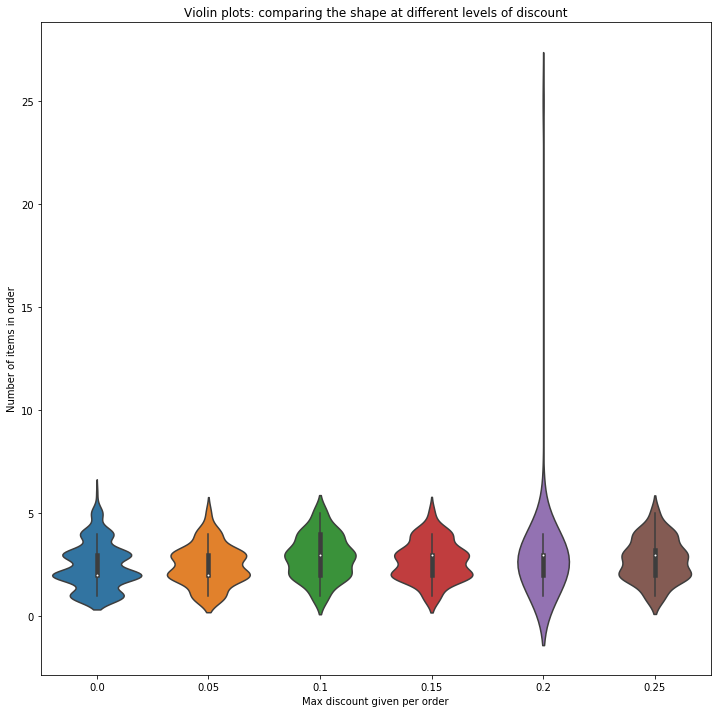

In [51]:
plt.figure(figsize=(12,12))
sns.violinplot(y='num_of_items',x='lvl_of_disc', data=df_order)
plt.title('Violin plots: comparing the shape at different levels of discount')
plt.xlabel('Max discount given per order')
plt.ylabel('Number of items in order');

So there seems to be an outlier at 20% discount. Lets take care of that and move onto testing.

In [59]:
df_order.num_of_items[df_order.lvl_of_disc == .2].max() #finding the max 

25

In [60]:
df_order[df_order.num_of_items == 25].index

Int64Index([829], dtype='int64')

In [61]:
df_order.drop(index=829, inplace=True)

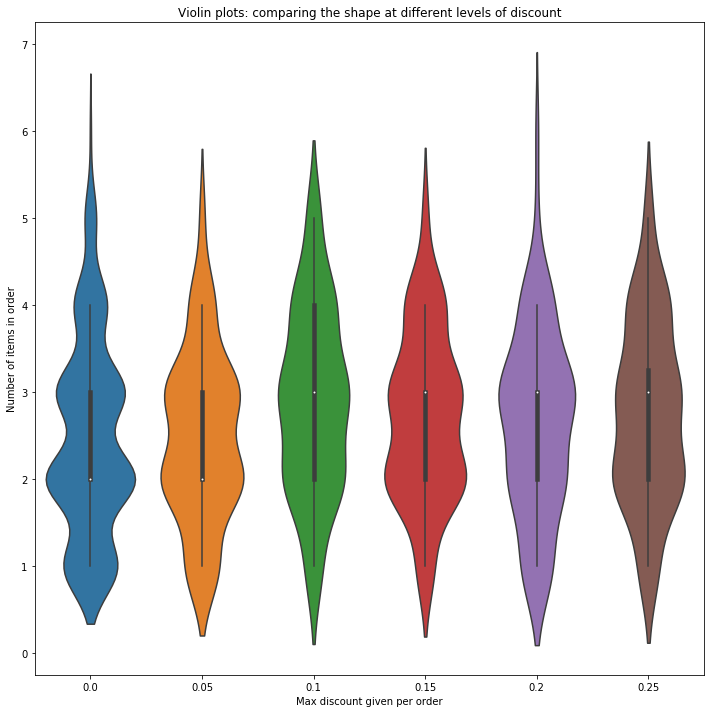

In [63]:
plt.figure(figsize=(12,12))
sns.violinplot(y='num_of_items',x='lvl_of_disc', data=df_order)
plt.title('Violin plots: comparing the shape at different levels of discount')
plt.xlabel('Max discount given per order')
plt.ylabel('Number of items in order');

### 1-2 Testing

Since there are multiple groups (levels of discount), an ANOVA test would be the best choice to use. The ANOVA test will show if there is a signifigant differece between no discount and discount. If there is a signifigant outcome, I plan on using the Tukey HSD (honestly significant difference) test to determine if the relationship between multiple levels of discount are statistically significant. This will be a post hoc test.


#### ANOVA
 
Checking the assumptions for an ANOVA testing. The assumptions apply to the residuals and not the variables themselves.
- Independence of cases.
- Normality of residuals
- Equality (or "homogeneity") of variances

Independence is met. Different orders from different customers meeting different demands. An ANOVA test is based on the F-statistic which is pretty robust and allows us to suspend some of the assumptions given the group sizes are roughly equal. We can verify the assumptions after the test by using the Levene’s or Omnibus test for homogeneity of variances and either the Jarque-Bera or Shapiro tests for Normality. More on this can be found _[here](https://pythonfordatascience.org/anova-python/)_.

Reformatting my hypothesis:  
$H_{o} : \mu_{no \space discount} = \mu_{discount}$  
$H_{\alpha} : \mu_{no \space discount} < \mu_{discount}$  
$\alpha = 0.05$

In [65]:
results = ols('num_of_items ~ C(lvl_of_disc)', data=df_order).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           num_of_items   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.012
Date:                Sun, 27 Jan 2019   Prob (F-statistic):             0.0106
Time:                        11:50:22   Log-Likelihood:                -1230.1
No. Observations:                 829   AIC:                             2472.
Df Residuals:                     823   BIC:                             2501.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.4667      0.050     48.858      0.000       2.368       2.566
C(lvl_of_disc)[T.0.05]     0.0217      0.126      0.172      0.863      -0.226       0.269
C(lvl_of_disc)[T.0.1]      0.4252      0.134      3.165      0.002       0.162       0.689
C(lvl_of_disc)[T.0.15]     0.2400      0.134      1.797      0.073      -0.022       0.502
C(lvl_of_disc)[T.0.2]      0.1861      0.136      1.369      0.171      -0.081       0.453
C(lvl_of_disc)[T.0.25]     0.2833      0.136      2.084      0.037       0.017       0.550
==============================================================================
Omnibus:                       25.511   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.512
Skew:                           0.418   Prob(JB):                     1.75e-06
Kurtosis:                       2.737   Cond. No.                         4.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Neither our Omnibus (homogenity) or Jarque-Bera (normailty) were signifigant meaning our assumptions for our test panned out. 

So focusing p-value of the F-statisic, it is less than our critical value. So there is a difference between the two groups and that means we have to dig a bit deeper. Finally to check at what level we see the biggest difference.

In [66]:
mc = MultiComparison(df_order.num_of_items, df_order.lvl_of_disc)
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 0.0    0.05   0.0217  -0.3383 0.3817 False 
 0.0    0.1    0.4252   0.0415 0.809   True 
 0.0    0.15    0.24   -0.1415 0.6215 False 
 0.0    0.2    0.1861  -0.2022 0.5744 False 
 0.0    0.25   0.2833   -0.105 0.6716 False 
 0.05   0.1    0.4035  -0.0815 0.8886 False 
 0.05   0.15   0.2183   -0.265 0.7016 False 
 0.05   0.2    0.1644  -0.3243 0.6531 False 
 0.05   0.25   0.2616   -0.227 0.7503 False 
 0.1    0.15  -0.1852  -0.6865 0.316  False 
 0.1    0.2   -0.2391  -0.7455 0.2673 False 
 0.1    0.25  -0.1419  -0.6483 0.3645 False 
 0.15   0.2   -0.0539  -0.5586 0.4509 False 
 0.15   0.25   0.0433  -0.4614 0.5481 False 
 0.2    0.25   0.0972  -0.4126 0.6071 False 
--------------------------------------------


### 1-3 Results

- We can reject our null hypothesis that concludes that there is __signifigant difference__ between discount and no discount (p-value < $\alpha$ :: 0.0106 < 0.05)  
- Comparing between the different levels of discount, the greatest effect is seen at no discount to a 10% discount. 
- Further testing needs to account for orders with different discount levels within the same order
___
___

# 2) Is there a difference in the money generated from sales between the North America office and the British Island office?

The employees of this company are based in two central locations. I want to know if one office does more business than the other. The metric will be money generated (products ordered * price) with the contact based from one office or another.

$H_{o} =$ The employees based out of the British Island office generates the same amount renvenue, per order, than the North American office.  
$H_{\alpha} =$ The employees based out of the British Island office generates less renvenue, per order, than the North American office.

### 2-1 Inital Analysis

During my EDA, the information for employee territory not specific for my needs. I will use the region they live in as the seperation.

In [162]:
q = '''SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS price, e.Region AS employ_from \
FROM OrderDetail od \
LEFT JOIN [Order] o ON od.OrderId = o.Id \
LEFT JOIN Employee e ON o.EmployeeId = e.Id
GROUP BY od.OrderId'''

df = pd.read_sql_query(q, engine)
df.head(10)

2019-01-27 15:04:51,878 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS price, e.Region AS employ_from FROM OrderDetail od LEFT JOIN [Order] o ON od.OrderId = o.Id LEFT JOIN EMployee e ON o.EmployeeId = e.Id
GROUP BY od.OrderId
2019-01-27 15:04:51,878 INFO sqlalchemy.engine.base.Engine ()


,OrderId,price,employ_from
0,10248,440.0,British Isles
1,10249,1863.4,British Isles
2,10250,1813.0,North America
3,10251,670.8,North America
4,10252,3730.0,North America
5,10253,1444.8,North America
6,10254,625.2,British Isles
7,10255,2490.5,British Isles
8,10256,517.8,North America
9,10257,1119.9,North America


In [163]:
df.shape

(830, 3)

Looks like we have all 830 orders, great.

In [164]:
df.groupby('employ_from')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
employ_from,,,,,,,,
British Isles,224.0,1687.615357,2203.222396,12.5,480.0,930.125,2023.65,16321.9
North America,606.0,1611.275165,1907.580217,18.4,481.1,1070.500,2028.65,17250.0


The average made by both offices are close to each other but there is far fewer sales made by the British office. This requires me to check out the assumptions before I run any sort of testing. Lets take a quick look at the distribution for both, but look at the above data there is likely to be outliers.

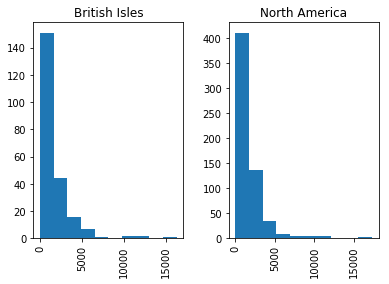

In [149]:
df.hist('price', by='employ_from');

There seems to be a few outliers. Lets take care of the egregious ones i.e. anything above 11K

In [150]:
df.price.sort_values(ascending=False)

617    17250.00
782    16321.90
733    15810.00
124    12281.20
176    11493.20
569    11490.70
641    11380.00
169    11283.20
649    10835.24
105    10741.60
267    10588.50
231    10495.60
292    10191.70
443    10164.80
784     8902.50
568     8891.00
266     8623.45
664     8267.40
112     7390.20
528     6984.50
773     6941.49
769     6750.00
745     6527.25
385     6483.05
359     6475.40
647     6379.40
364     6375.00
347     6300.00
439     6201.90
599     6164.90
         ...   
83        88.50
505       88.00
819       86.85
33        86.50
143       86.40
771       76.00
341       72.00
639       70.00
744       69.60
715       68.00
354       65.00
435       63.00
383       62.00
789       60.00
372       57.50
506       55.20
490       52.35
174       49.80
23        48.00
809       45.00
652       45.00
803       45.00
426       45.00
567       40.00
635       36.00
650       30.00
338       28.00
519       28.00
559       18.40
534       12.50
Name: price, Length: 830

In [151]:
to_drop = [617,782,733,124,176,569,641,169]
df.drop(index=to_drop,inplace=True)

In [152]:
brit = df[df.employ_from == 'British Isles']
merica = df[df.employ_from == 'North America']
brit.describe(), merica.describe()

(            OrderId         price
 count    220.000000    220.000000
 mean   10664.827273   1484.316091
 std      235.640635   1594.673307
 min    10248.000000     12.500000
 25%    10487.500000    479.850000
 50%    10666.500000    920.300000
 75%    10868.250000   1943.500000
 max    11074.000000  10741.600000,             OrderId         price
 count    602.000000    602.000000
 mean   10660.827243   1529.233970
 std      241.085475   1611.180311
 min    10250.000000     18.400000
 25%    10449.250000    479.762500
 50%    10659.000000   1061.200000
 75%    10870.750000   1972.202500
 max    11077.000000  10835.240000)

In [138]:
levene(brit['price'], merica['price'])

LeveneResult(statistic=7.759492508454024e-06, pvalue=0.9977781038750253)

Levene’s test for homogeneity of variance is not significant which indicates that the groups have equal variances.

In [143]:
shapiro(df.price)

(0.7539790868759155, 3.1285300929135314e-33)

## 2-2 Testing

### 2-3 Results

$H_{o} =$ Having manager in your title, the amount a cusomter orders doesn't change  
$H_{\alpha} =$ Having manager in your title, the amount a customer orders increases

In [165]:
get_column_info('Customer')

Table Name: Customer 

Id  ||PRIMARY KEY||  dtype: VARCHAR(8000)
CompanyName     dtype: VARCHAR(8000)
ContactName     dtype: VARCHAR(8000)
ContactTitle     dtype: VARCHAR(8000)
Address     dtype: VARCHAR(8000)
City     dtype: VARCHAR(8000)
Region     dtype: VARCHAR(8000)
PostalCode     dtype: VARCHAR(8000)
Country     dtype: VARCHAR(8000)
Phone     dtype: VARCHAR(8000)
Fax     dtype: VARCHAR(8000)


In [171]:
q = '''SELECT c.CompanyName, c.ContactTitle, COUNT(*) \
FROM OrderDetail od \
LEFT JOIN [Order] o ON od.OrderId = o.Id \
LEFT JOIN Customer c ON c.Id = o.CustomerId \
GROUP BY c.CompanyName'''

df = pd.read_sql_query(q, engine)
df

2019-01-27 15:21:41,441 INFO sqlalchemy.engine.base.Engine SELECT c.CompanyName, c.ContactTitle, COUNT(*) FROM OrderDetail od LEFT JOIN [Order] o ON od.OrderId = o.Id LEFT JOIN Customer c ON c.Id = o.CustomerId GROUP BY c.CompanyName
2019-01-27 15:21:41,442 INFO sqlalchemy.engine.base.Engine ()


,CompanyName,ContactTitle,COUNT(*)
0,None,None,77
1,Alfreds Futterkiste,Sales Representative,12
2,Ana Trujillo Emparedados y helados,Owner,10
3,Around the Horn,Sales Representative,30
4,B's Beverages,Sales Representative,22
5,Berglunds snabbköp,Order Administrator,52
6,Blauer See Delikatessen,Sales Representative,14
7,Blondesddsl père et fils,Marketing Manager,26
8,Bon app,Owner,44
9,Bottom-Dollar Markets,Accounting Manager,35


In [172]:
df.ContactTitle.value_counts()

Sales Representative              17
Owner                             14
Marketing Manager                 12
Sales Manager                     11
Accounting Manager                 9
Sales Associate                    7
Marketing Assistant                5
Sales Agent                        4
Assistant Sales Agent              2
Order Administrator                2
Owner/Marketing Assistant          1
Assistant Sales Representative     1
Name: ContactTitle, dtype: int64

# READY TO RUN TESTS

$H_{o} =$ Given the product is perishable, it ships within the same region  
$H_{\alpha} =$ Given the product is perishable, the product ships out of the region 